Extracting features...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-afb88766ccf0>:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Preparing data...
Extracting features...
Epoch 1/15
Train Loss: 1.5950, Acc: 0.2668
Val Loss: 1.4184, Acc: 0.3999
Epoch 2/15
Train Loss: 1.1934, Acc: 0.4950
Val Loss: 0.9287, Acc: 0.6118
Epoch 3/15
Train Loss: 0.9306, Acc: 0.6151
Val Loss: 0.9020, Acc: 0.6132
Epoch 4/15
Train Loss: 0.8506, Acc: 0.6507
Val Loss: 0.9410, Acc: 0.6045
Epoch 5/15
Train Loss: 0.7823, Acc: 0.6812
Val Loss: 0.9182, Acc: 0.6091
Epoch 6/15
Train Loss: 0.7136, Acc: 0.7158
Val Loss: 0.9573, Acc: 0.6124
Early stopping triggered


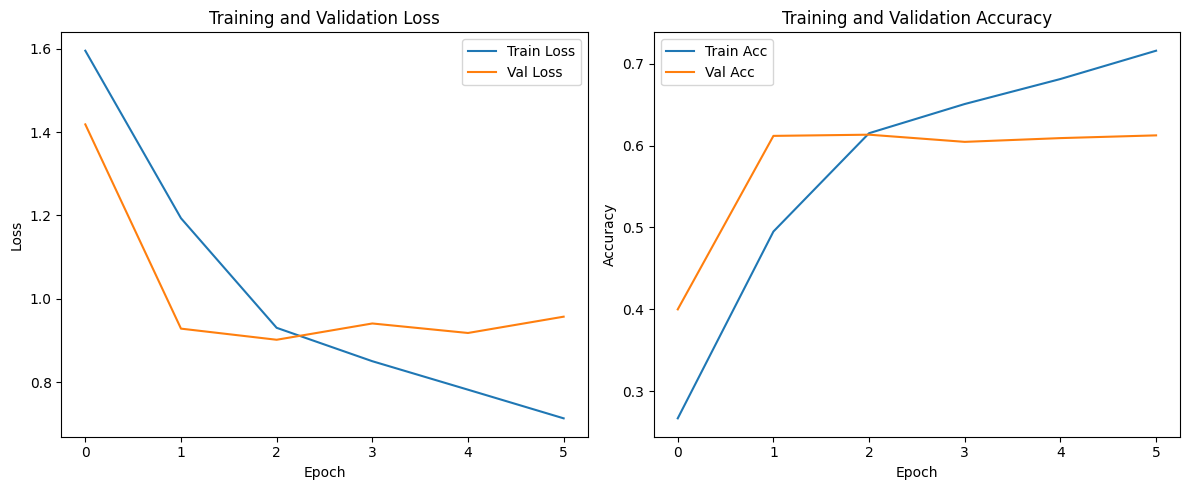

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import spacy
from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])
st_model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class EnhancedRoberta(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        # Initialize RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Define additional layers
        self.layer1 = nn.Linear(input_dim, 1024)  # Input dimension is now 1156
        self.bn1 = nn.BatchNorm1d(1024)
        self.layer2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.layer3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, features):
        # Get RoBERTa output
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = roberta_output.last_hidden_state[:, 0, :]  # Use [CLS] token representation (768 dimensions)

        # Concatenate with engineered features
        combined_features = torch.cat([pooled_output, features], dim=1)  # Combined features: 768 + 388 = 1156

        # Pass through additional layers
        h1 = F.gelu(self.bn1(self.layer1(combined_features)))
        h1 = self.dropout(h1)

        h2 = F.gelu(self.bn2(self.layer2(h1)))
        h2 = self.dropout(h2)

        h3 = F.gelu(self.bn3(self.layer3(h2)))
        h3 = self.dropout(h3)

        # Final classification
        output = self.classifier(h3)
        return output

class GPUOptimizedTrainer:
    def __init__(self, texts, labels, batch_size=32, val_split=0.2):
        self.device = torch.device('cuda')
        self.batch_size = batch_size

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Extract features to determine feature dimension
        self.feature_dim = self.extract_features(texts[:1]).shape[1]  # Get feature dimension from a single sample

        # RoBERTa's [CLS] token has 768 dimensions + engineered features
        input_dim = 768 + self.feature_dim

        self.model = EnhancedRoberta(input_dim=input_dim, num_classes=5).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(texts, labels, val_split)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")

        def extract_contextual(texts, batch_size=128):
            features = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i + batch_size]
                with torch.no_grad():
                    embeddings = st_model.encode(batch, convert_to_tensor=True)
                    features.extend(embeddings.cpu().numpy())
            return np.array(features)

        def extract_syntactic(texts):
            features = []
            for text in texts:
                doc = nlp(text)
                pos_tags = [token.pos_ for token in doc]

                features.append([
                    len(doc),  # document length
                    len(set(pos_tags)) / len(pos_tags),  # POS diversity
                    pos_tags.count('NOUN') / len(pos_tags),  # noun ratio
                    pos_tags.count('VERB') / len(pos_tags),  # verb ratio
                ])
            return np.array(features)

        contextual_features = extract_contextual(texts)
        syntactic_features = extract_syntactic(texts)

        return np.hstack([contextual_features, syntactic_features])

    def prepare_data(self, texts, labels, val_split):
        print("Preparing data...")

        # Tokenize the text data
        encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        # Extract engineered features
        features = self.extract_features(texts)

        # Normalize features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Split data
        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))

        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(features[train_idx], dtype=torch.float32)
        self.train_labels = torch.tensor(labels[train_idx], dtype=torch.long)

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(features[val_idx], dtype=torch.float32)
        self.val_labels = torch.tensor(labels[val_idx], dtype=torch.long)

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2,  # Reduced to avoid warnings
            prefetch_factor=3,
            persistent_workers=True
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size * 2,
            pin_memory=True,
            num_workers=2  # Reduced to avoid warnings
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=1e-5,
            weight_decay=0.1,
            betas=(0.9, 0.999)
        )

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=2e-5,
            epochs=15,
            steps_per_epoch=len(self.train_loader),
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=3)

    def train(self, epochs=15):
        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

            self.scheduler.step()

        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(self.train_loader):
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target)

            self.scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)
            self.scheduler.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_ids, attention_mask, features, target in self.val_loader:
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

if __name__ == "__main__":
    data_path = "/content/mini_df.csv"
    df = pd.read_csv(data_path)
    #df['text'] = df['modified_text']
    #df.drop(columns=["Unnamed: 0", "modified_text"], inplace=True)
    df["label"] = df["rating"] - 1
    texts = df["text"].tolist()
    labels = np.array(df["label"].tolist())

    trainer = GPUOptimizedTrainer(texts, labels)
    metrics = trainer.train()

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Extracting features...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-f7bd65722150>:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Preparing data...
Extracting features...
Epoch 1/15
Train Loss: 1.5398, Acc: 0.2921
Val Loss: 1.3810, Acc: 0.4143
Epoch 2/15
Train Loss: 1.2218, Acc: 0.4751
Val Loss: 0.9858, Acc: 0.5901
Epoch 3/15
Train Loss: 1.0150, Acc: 0.5832
Val Loss: 0.9478, Acc: 0.6045
Epoch 4/15
Train Loss: 0.9610, Acc: 0.6011
Val Loss: 0.9235, Acc: 0.6116
Epoch 5/15
Train Loss: 0.9027, Acc: 0.6342
Val Loss: 0.9278, Acc: 0.6155
Epoch 6/15
Train Loss: 0.8557, Acc: 0.6536
Val Loss: 0.9113, Acc: 0.6185
Epoch 7/15
Train Loss: 0.8277, Acc: 0.6672
Val Loss: 0.9227, Acc: 0.6095
Epoch 8/15
Train Loss: 0.7831, Acc: 0.6849
Val Loss: 0.9552, Acc: 0.6015
Epoch 9/15
Train Loss: 0.7241, Acc: 0.7151
Val Loss: 0.9965, Acc: 0.6018
Early stopping triggered


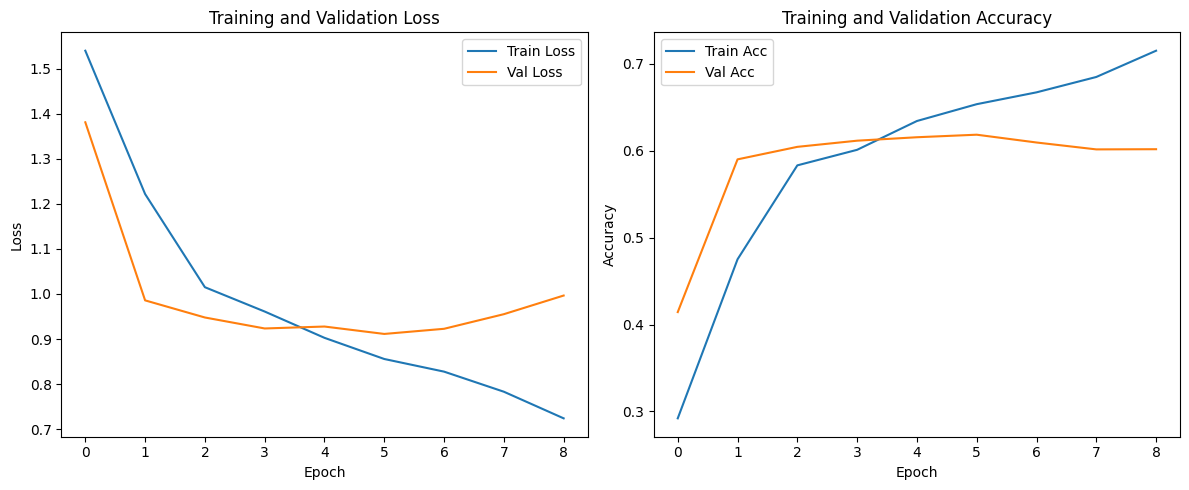

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import spacy
from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])
st_model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class EnhancedRoberta(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        # Initialize RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Define additional layers with increased dropout
        self.layer1 = nn.Linear(input_dim, 1024)  # Input dimension is now 1156
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)  # Increased dropout for regularization
        self.layer2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)  # Increased dropout for regularization
        self.layer3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)  # Increased dropout for regularization
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, features):
        # Get RoBERTa output
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = roberta_output.last_hidden_state[:, 0, :]  # Use [CLS] token representation (768 dimensions)

        # Concatenate with engineered features
        combined_features = torch.cat([pooled_output, features], dim=1)  # Combined features: 768 + 388 = 1156

        # Pass through additional layers with dropout
        h1 = F.gelu(self.bn1(self.layer1(combined_features)))
        h1 = self.dropout1(h1)

        h2 = F.gelu(self.bn2(self.layer2(h1)))
        h2 = self.dropout2(h2)

        h3 = F.gelu(self.bn3(self.layer3(h2)))
        h3 = self.dropout3(h3)

        # Final classification
        output = self.classifier(h3)
        return output

class GPUOptimizedTrainer:
    def __init__(self, texts, labels, batch_size=32, val_split=0.2):
        self.device = torch.device('cuda')
        self.batch_size = batch_size

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Extract features to determine feature dimension
        self.feature_dim = self.extract_features(texts[:1]).shape[1]  # Get feature dimension from a single sample

        # RoBERTa's [CLS] token has 768 dimensions + engineered features
        input_dim = 768 + self.feature_dim

        self.model = EnhancedRoberta(input_dim=input_dim, num_classes=5).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(texts, labels, val_split)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")

        def extract_contextual(texts, batch_size=128):
            features = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i + batch_size]
                with torch.no_grad():
                    embeddings = st_model.encode(batch, convert_to_tensor=True)
                    features.extend(embeddings.cpu().numpy())
            return np.array(features)

        def extract_syntactic(texts):
            features = []
            for text in texts:
                doc = nlp(text)
                pos_tags = [token.pos_ for token in doc]

                features.append([
                    len(doc),  # document length
                    len(set(pos_tags)) / len(pos_tags),  # POS diversity
                    pos_tags.count('NOUN') / len(pos_tags),  # noun ratio
                    pos_tags.count('VERB') / len(pos_tags),  # verb ratio
                ])
            return np.array(features)

        contextual_features = extract_contextual(texts)
        syntactic_features = extract_syntactic(texts)

        return np.hstack([contextual_features, syntactic_features])

    def prepare_data(self, texts, labels, val_split):
        print("Preparing data...")

        # Tokenize the text data
        encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        # Extract engineered features
        features = self.extract_features(texts)

        # Normalize features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Split data
        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))

        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(features[train_idx], dtype=torch.float32)
        self.train_labels = torch.tensor(labels[train_idx], dtype=torch.long)

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(features[val_idx], dtype=torch.float32)
        self.val_labels = torch.tensor(labels[val_idx], dtype=torch.long)

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2,  # Reduced to avoid warnings
            prefetch_factor=3,
            persistent_workers=True
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size * 2,
            pin_memory=True,
            num_workers=2  # Reduced to avoid warnings
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=1e-5,
            weight_decay=0.1,  # Weight decay for regularization
            betas=(0.9, 0.999)
        )

        # Use ReduceLROnPlateau for dynamic learning rate adjustment
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',  # Monitor validation loss
            factor=0.1,  # Reduce LR by a factor of 0.1
            patience=2,  # Wait for 2 epochs without improvement
            verbose=True
        )

        self.early_stopping = EarlyStopping(patience=3)

    def train(self, epochs=15):
        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

            # Adjust learning rate based on validation loss
            self.scheduler.step(val_metrics['loss'])

        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(self.train_loader):
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target)

            self.scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_ids, attention_mask, features, target in self.val_loader:
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

if __name__ == "__main__":
    data_path = "/content/mini_df.csv"
    df = pd.read_csv(data_path)
    df["label"] = df["rating"] - 1
    texts = df["text"].tolist()
    labels = np.array(df["label"].tolist())

    trainer = GPUOptimizedTrainer(texts, labels)
    metrics = trainer.train()

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Extracting features...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-4ade9511bc42>:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Preparing data...
Extracting features...
Epoch 1/15
Train Loss: 1.5532, Acc: 0.3012
Val Loss: 1.1556, Acc: 0.5070
Epoch 2/15
Train Loss: 1.0803, Acc: 0.5486
Val Loss: 1.0272, Acc: 0.5713
Epoch 3/15
Train Loss: 0.9622, Acc: 0.6027
Val Loss: 0.9250, Acc: 0.6143
Epoch 4/15
Train Loss: 0.8890, Acc: 0.6359
Val Loss: 0.9316, Acc: 0.6145
Epoch 5/15
Train Loss: 0.8190, Acc: 0.6714
Val Loss: 0.9514, Acc: 0.6101
Epoch 6/15
Train Loss: 0.7410, Acc: 0.7133
Val Loss: 0.9874, Acc: 0.6109
Early stopping triggered


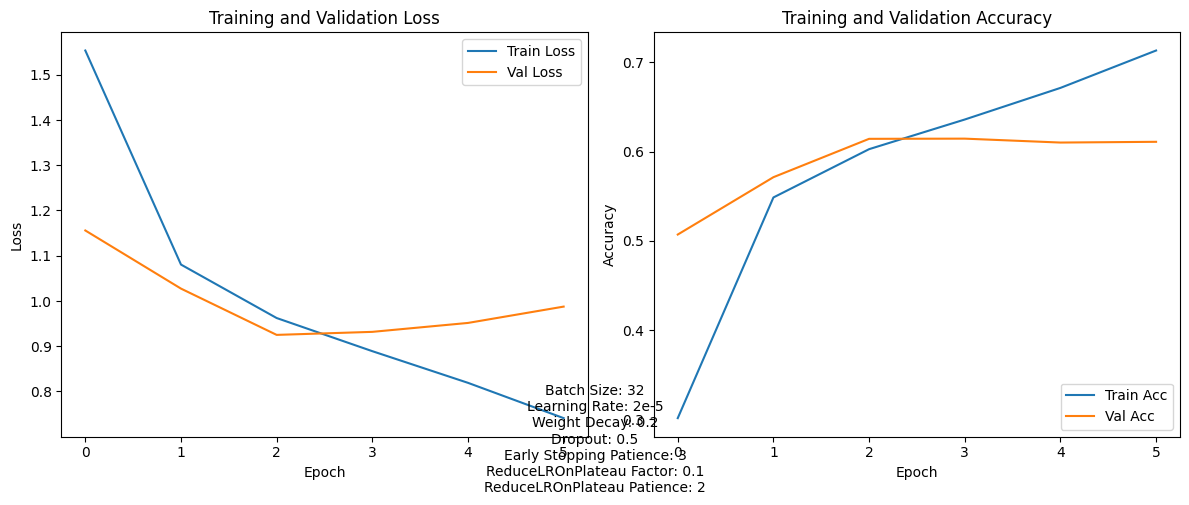

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import spacy
from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])
st_model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class EnhancedRoberta(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        # Initialize RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Define additional layers with increased dropout and reduced architecture
        self.layer1 = nn.Linear(input_dim, 512)  # Reduced from 1024 to 512
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)  # Increased dropout for regularization
        self.layer2 = nn.Linear(512, 256)  # Reduced from 512 to 256
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)  # Increased dropout for regularization
        self.classifier = nn.Linear(256, num_classes)  # Directly classify from 256

    def forward(self, input_ids, attention_mask, features):
        # Get RoBERTa output
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = roberta_output.last_hidden_state[:, 0, :]  # Use [CLS] token representation (768 dimensions)

        # Concatenate with engineered features
        combined_features = torch.cat([pooled_output, features], dim=1)  # Combined features: 768 + 388 = 1156

        # Pass through additional layers with dropout
        h1 = F.gelu(self.bn1(self.layer1(combined_features)))
        h1 = self.dropout1(h1)

        h2 = F.gelu(self.bn2(self.layer2(h1)))
        h2 = self.dropout2(h2)

        # Final classification
        output = self.classifier(h2)
        return output

class GPUOptimizedTrainer:
    def __init__(self, texts, labels, batch_size=32, val_split=0.2):
        self.device = torch.device('cuda')
        self.batch_size = batch_size

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Extract features to determine feature dimension
        self.feature_dim = self.extract_features(texts[:1]).shape[1]  # Get feature dimension from a single sample

        # RoBERTa's [CLS] token has 768 dimensions + engineered features
        input_dim = 768 + self.feature_dim

        self.model = EnhancedRoberta(input_dim=input_dim, num_classes=5).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(texts, labels, val_split)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")

        def extract_contextual(texts, batch_size=128):
            features = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i + batch_size]
                with torch.no_grad():
                    embeddings = st_model.encode(batch, convert_to_tensor=True)
                    features.extend(embeddings.cpu().numpy())
            return np.array(features)

        def extract_syntactic(texts):
            features = []
            for text in texts:
                doc = nlp(text)
                pos_tags = [token.pos_ for token in doc]

                features.append([
                    len(doc),  # document length
                    len(set(pos_tags)) / len(pos_tags),  # POS diversity
                    pos_tags.count('NOUN') / len(pos_tags),  # noun ratio
                    pos_tags.count('VERB') / len(pos_tags),  # verb ratio
                ])
            return np.array(features)

        contextual_features = extract_contextual(texts)
        syntactic_features = extract_syntactic(texts)

        return np.hstack([contextual_features, syntactic_features])

    def prepare_data(self, texts, labels, val_split):
        print("Preparing data...")

        # Tokenize the text data
        encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        # Extract engineered features
        features = self.extract_features(texts)

        # Normalize features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Split data
        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))

        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(features[train_idx], dtype=torch.float32)
        self.train_labels = torch.tensor(labels[train_idx], dtype=torch.long)

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(features[val_idx], dtype=torch.float32)
        self.val_labels = torch.tensor(labels[val_idx], dtype=torch.long)

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2,  # Reduced to avoid warnings
            prefetch_factor=3,
            persistent_workers=True
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size * 2,
            pin_memory=True,
            num_workers=2  # Reduced to avoid warnings
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=2e-5,  # Adjusted learning rate
            weight_decay=0.2,  # Increased weight decay for regularization
            betas=(0.9, 0.999)
        )

        # Use ReduceLROnPlateau for dynamic learning rate adjustment
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',  # Monitor validation loss
            factor=0.1,  # Reduce LR by a factor of 0.1
            patience=2,  # Wait for 2 epochs without improvement
            verbose=True
        )

        self.early_stopping = EarlyStopping(patience=3)

    def train(self, epochs=15):
        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

            # Adjust learning rate based on validation loss
            self.scheduler.step(val_metrics['loss'])

        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(self.train_loader):
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target)

            self.scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_ids, attention_mask, features, target in self.val_loader:
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Updated autocast syntax
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

if __name__ == "__main__":
    data_path = "/content/mini_df.csv"
    df = pd.read_csv(data_path)
    df["label"] = df["rating"] - 1
    texts = df["text"].tolist()
    labels = np.array(df["label"].tolist())

    trainer = GPUOptimizedTrainer(texts, labels)
    metrics = trainer.train()

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')  # Single legend for both curves

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')  # Single legend for both curves

    # Add hyperparameters outside the graph
    hyperparams = (
        f"Batch Size: {trainer.batch_size}\n"
        f"Learning Rate: 2e-5\n"
        f"Weight Decay: 0.2\n"
        f"Dropout: 0.5\n"
        f"Early Stopping Patience: 3\n"
        f"ReduceLROnPlateau Factor: 0.1\n"
        f"ReduceLROnPlateau Patience: 2"
    )
    plt.figtext(0.5, 0.01, hyperparams, wrap=True, horizontalalignment='center', fontsize=10)

    plt.tight_layout()
    plt.show()